With this post I explore an alternative to ol' numpy; [xarray](http://xarray.pydata.org/en/stable/index.html). Numpy is still running under the hood but this very handy library applies the [pandas](http://pandas.pydata.org/) concept of labeled dimension to large N-dimension arrays prevalent in scientific computing. The result is an ease of manipulation of dimensions without having to guess or remember what they correspond to. Moreover, xarray plays nicely with two other relatively new libraries:
* [dask](http://dask.pydata.org/en/latest/), which enables out of core computation so that memory availability becomes much less an issue with large data sets; 
* [GeoViews](http://geo.holoviews.org/), a library sitting on top of [HoloViews](http://holoviews.org/). The latter eases the burden of data visualization by offering an unusual approach that does away with step-by-step graphical coding and allows the user to concentrate how the data organization instead. This results in a substantial reduction code written, which makes data analysis much cleaner and less bug-prone. GeoViews sits on top of the visualization package HoloViews, with an emphasis on geophysical data. It's also my first good-bye to the aging (10+ years) matplotlib library. It'll still be handy now and then, but it's time to try new things. 
<!-- TEASER_END -->

In [1]:
import xarray as xr
import os
import seaborn
from matplotlib import rcParams
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
rcParams['font.size']=16
rcParams['xtick.labelsize']=14
rcParams['ytick.labelsize']=14
rcParams['legend.fontsize']=14
rcParams['axes.formatter.limits'] = (-3,3)

Set up the paths for loading and saving...

In [3]:
dataDir = '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/'
expDir = 'Lt'
fname = 'S20031932003196.L3m_4D_SU50.nc'
fpath = os.path.join(dataDir,expDir,fname)
foutpath = os.path.join(dataDir,expDir,fname.split('.nc')[0] + '_xarray.nc')

..., which I now used to access the nc data:

In [4]:
ds = xr.open_dataset(fpath)

Now let's peak inside the dataset we've just loaded:

In [5]:
ds.data_vars.keys()

KeysView(Data variables:
    Rrs_unc_412  (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    Rrs_unc_443  (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    Rrs_unc_490  (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    Rrs_unc_510  (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    Rrs_unc_555  (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    Rrs_unc_670  (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    palette      (rgb, eightbitcolor) uint8 147 0 108 144 0 111 141 0 114 ...)

Here Rrs refers to Remote sensing reflectance (units of per steradian or $sr^{-1}$). The number at the end of the label string refers to the corresponding wavelength, in nanometers.

I don't need "palette". I am interested in the uncertainty data, however. These are 64 bits float with lat lon dimensions. Let's make sure these arrays are inter-comparable.

In [6]:
bands = ['412','443','490','510','555','670']
for band in bands:
    var = ds.data_vars['Rrs_unc_%s' % band]
    print(var)
    print("=" * 80)

<xarray.DataArray 'Rrs_unc_412' (lat: 1556, lon: 4318)>
[6718808 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 81.17 81.08 81.0 80.92 80.83 80.75 80.67 80.58 ...
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.7 -179.6 -179.5 -179.4 ...
Attributes:
    long_name: Uncertainty in remote sensing reflectance at 412 nm
    units: sr^-1
    valid_min: -30000
    valid_max: 25000
    display_scale: linear
    display_min: 0.0
    display_max: 0.01
<xarray.DataArray 'Rrs_unc_443' (lat: 1556, lon: 4318)>
[6718808 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 81.17 81.08 81.0 80.92 80.83 80.75 80.67 80.58 ...
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.7 -179.6 -179.5 -179.4 ...
Attributes:
    long_name: Uncertainty in remote sensing reflectance at 443 nm
    units: sr^-1
    valid_min: -30000
    valid_max: 25000
    display_scale: linear
    display_min: 0.0
    display_max: 0.01
<xarray.DataArray 'Rrs_unc_490' (lat: 1556, lon: 4318)>
[6

So there are multiple arrays, one for each of 6 bands.
Now I want to reorganize the data into a single array with a third dimension; band.
This is as easy as 1, 2, 3... lines of code

In [7]:
rrsUnc = xr.concat((ds.data_vars['Rrs_unc_%s' % band] for band in bands), dim='bands')
rrsUnc.coords['bands'] = ['412', '443', '490', '510', '555', '670']
rrsUnc.name = 'rrs_uncertainty'

Now I can close the netcdf dataset handle. Note that the \__enter\__() and \__exit\__() methods being implemented, sticking the code above inside a "with" context would be the proper way to go about this; it'll also be how I'll do things next time.

In [8]:
ds.close()

So what is rrs?...

In [9]:
type(rrsUnc)

xarray.core.dataarray.DataArray

... and what are the dimensions of rrs data ?...

In [10]:
print(rrsUnc.dims)

('bands', 'lat', 'lon')


... and for indexing purposes, what type are they?

In [11]:
print(rrsUnc.coords)

Coordinates:
  * lat      (lat) float64 81.17 81.08 81.0 80.92 80.83 80.75 80.67 80.58 ...
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.7 -179.6 -179.5 -179.4 ...
  * bands    (bands) <U3 '412' '443' '490' '510' '555' '670'


#### Basic data manipulation and plotting

Accessing the data along a given dimension...

In [12]:
rrsUnc412 = rrsUnc.sel(bands=['412'])
rrsUncGreen = rrsUnc.sel(bands=['510','555'])

... and quickly plotting it via its matplotlib interface is pretty straightforward:

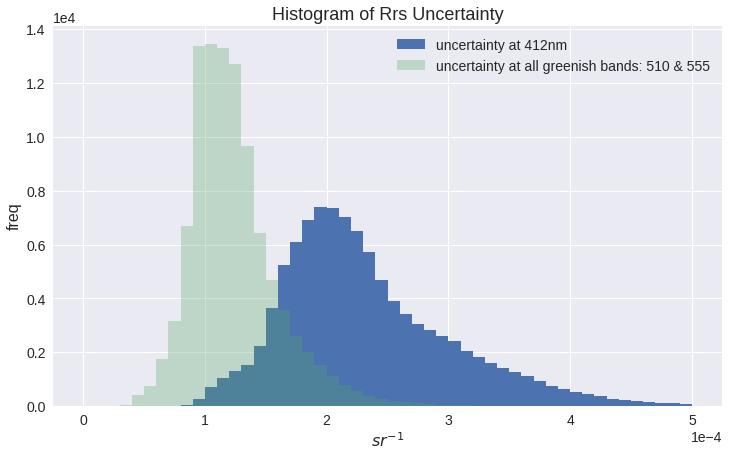

In [13]:
pl.figure(figsize=(12,7))
rrsUnc412.plot.hist(bins=50, range=(0,5e-4), histtype='stepfilled', label='uncertainty at 412nm',
                normed=True);
rrsUncGreen.plot.hist(bins=50, range=(0,5e-4),histtype='stepfilled', alpha=0.3,
                  label='uncertainty at all greenish bands: 510 & 555', normed=True)
pl.legend();
pl.title('Histogram of Rrs Uncertainty',fontsize=18);
pl.ylabel('freq', fontsize=16)
pl.xlabel(r'$sr^{-1}$', fontsize=16 );

#### Storing

*rrs* is a xarray DataArray type. To write the data it contains to netcdf format I first need to convert it to an xarray DataSet type, which then gives me the facility to export it to netcdf.

In [14]:
dsUncNew = rrsUnc.to_dataset()

In [15]:
type(dsUncNew)

xarray.core.dataset.Dataset

In [16]:
dsUncNew.to_netcdf(path=foutpath, engine='netcdf4')

That's it! In the next [post](https://madhatter106.github.io/DataScienceCorner/posts/xarray-geoviews-a-new-perspective-on-oceanographic-data-part-ii/), I will continue with some more data organization and shape the data for visualization using GeoViews. Happy hacking!